This notebook contains the inference and also ensemble of the models based on majority voting

The tests are made based on validation set in order to see the success of the ensemble model.

In [1]:
# Load libraries
import torch
from tqdm import tqdm
import pickle
import numpy as np
import scipy.stats
import os
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

import os
import sys; sys.path.insert(0, os.path.abspath("../../"))
import cv2
import numpy as np
import pandas as pdc
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import time
import copy
import timm
from prettytable import PrettyTable

import logging
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

## paths
this_path = Path().resolve()
binary_data = this_path.parent.parent/'data_processed/binary/'
models_path = this_path.parent.parent/'models/binary/'

# device setting 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
experiment_no = 'exp15-4-4'
network_arch = 'swin_t'

experiment_path = models_path/network_arch/experiment_no
experiment_path.mkdir(parents=True, exist_ok=True)

cfg = {
    'data': {
        'exp_name' : network_arch + '/' + experiment_no,
        'data_dir' : binary_data,
        'chkpt_path' : experiment_path,
        'best_model_path' : experiment_path/"best_model.pt",
        'tensorboard_path' : models_path/'tensorboard/',
        },
    'train': {
        'epochs' : 70,
        'batch_size' : 25,
        'lr' : 0.0001, # deafult:0.0001
        'momentum' : 0.9,
        'weight_decay' : 0.00005,
        'num_workers' : 2,
        'lr_step_size' : 5,
        'gamma' : 0.1,
        'sch_patience': 7,
        'sch_thresh': 0.01,
        'es_patience': 15,
        'es_delta': 0.02,
        'cuda': 'cuda:0',
        },
    'val': {
        'batch_size' : 25,
        'num_workers' : 2,
        }
}

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation((0, 70), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.RandomEqualize(),
        # transforms.RandomAffine(degrees=(-30,30), translate=(0.1, 0.2), scale=(0.95, 1.2)),
        transforms.ColorJitter(brightness=0.1, hue=0.1),
        transforms.GaussianBlur(kernel_size=(3,9)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


datasets = {x: datasets.ImageFolder(os.path.join(cfg['data']['data_dir'], x), transform=data_transforms[x])
            for x in ['train', 'val']}
            
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

class_names = datasets['train'].classes

device = torch.device(cfg['train']['cuda'] if torch.cuda.is_available() else "cpu") # "cpu"


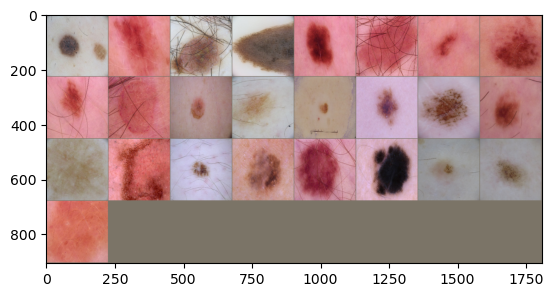

In [4]:
dataloaders = {
        'val': DataLoader(
            datasets['val'], batch_size=cfg['val']['batch_size'],
            num_workers=cfg['val']['num_workers'], drop_last=True),
        'train': DataLoader(
            datasets['train'], batch_size=cfg['train']['batch_size'],
            shuffle=True, num_workers=cfg['val']['num_workers'], drop_last=True)
    }

#show the validation images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=None)

In [5]:
# load the 1st model: swin_t/exp15-4

def load_model(model_path):
    loaded_model = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)
    num_ftrs = loaded_model.head.in_features
    loaded_model.head = nn.Linear(num_ftrs, 2)
    checkpoint = torch.load(model_path)
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.to(device)

    return loaded_model

In [40]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score


model_path1 = models_path/network_arch/'exp15-4'/'best_model.pt'
model1 = load_model(model_path1)

model_path2 = models_path/"vit"/'exp15'/'best_model.pt'
model2 = load_model(model_path2)

model_path3 = models_path/network_arch/'exp15-4-3'/'best_model.pt'
model3 = load_model(model_path3)

# Set the models to eval mode (optional, but recommended)
model1.eval()
model2.eval()
model3.eval()

# Define a function to get the predictions from a single model
def get_predictions(model, data):
  # Run the model on the data
  logits = model(data)
  # Get the class with the highest probability for each sample
  _, predicted_classes = logits.max(dim=1)
  predicted_classes = predicted_classes.to(torch.int64)
  return predicted_classes


total_acc = 0 
total = 0 
num_of_batches = 0
# Iterate over the data
for data, labels in dataloaders['val']:
  # Get the predictions from each model
  data = data.to(device)
  labels = labels.to(device)

  predictions1 = get_predictions(model1, data)
  predictions2 = get_predictions(model2, data)
  predictions3 = get_predictions(model3, data)

  stack = torch.stack([predictions1, predictions2, predictions3])

  # convert to numpy
  stack = stack.cpu().numpy()
  labels = labels.cpu().numpy()

  # Get the majority class for each sample
  ensemble_output = scipy.stats.mode(stack, axis=0).mode[0]

  # print(f"predictions1: {predictions1}" )
  # print(f"predictions2: {predictions2}" )
  # print(f"predictions3: {predictions3}" )
  # print(f"output: {ensemble_output}" )

  # Evaluation of Ensemble Model
  total += len(labels) # total number of val images = 3775 (151 batches * 25 images per batch)

  running_accuracy = accuracy_score(labels, ensemble_output)
  total_acc += running_accuracy
  num_of_batches += 1 # number of batches is determined based on the epoch size (if epoch size is 25, then num_of_batches = 151 for 3775 val images)

# takes the average of the accuracy of each batch
print('Accuracy of the model based on the val set of inputs is: %d %%' % (100 * total_acc / num_of_batches)) 


Accuracy of the model based on the val set of inputs is: 90 %
